In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import time

In [2]:
# load + preprocess image
def load_image(img_path, target_size=(256, 256)):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0
    return img


In [3]:
# UNet
def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model


In [4]:
# DnCNN
def build_dncnn(input_shape=(256, 256, 3), depth=17, num_filters=64):
    input_img = Input(shape=input_shape)
    x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(input_img)
    for _ in range(depth - 2):
        x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    model = Model(input_img, x)
    return model


In [5]:
# ResNet
def build_resnet(input_shape=(256, 256, 3)):
    base_model = tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(3, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model


In [6]:
# PSNR
def compute_psnr(original, denoised):
    original = np.clip(original, 0., 1.)
    denoised = np.clip(denoised, 0., 1.)
    return peak_signal_noise_ratio(original, denoised)


# SSIM
def compute_ssim(original, denoised):
    original = np.clip(original, 0., 1.)
    denoised = np.clip(denoised, 0., 1.)
    return structural_similarity(original, denoised, channel_axis=-1)


# generation time
def measure_time(model, noisy_img):
    start_time = time.time()
    denoised_img = model.predict(np.expand_dims(noisy_img, axis=0))
    end_time = time.time()
    return denoised_img, end_time - start_time


In [7]:
img_path = '/content/image_0.PNG'   # changge into your image path
input_img = load_image(img_path)

In [8]:
# Plot training performance
def plot_performance(time_steps, mse_losses, psnr_values, ssim_values):
    # for MSE
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(time_steps, mse_losses, label='MSE', color='red')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('MSE')
    ax1.legend()
    plt.show()

    # for PSNR and SSIM
    fig, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(time_steps, psnr_values, label='PSNR', color='blue')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('PSNR')
    ax2.legend(loc='upper left')

    ax3 = ax2.twinx()
    ax3.plot(time_steps, ssim_values, label='SSIM', color='green')
    ax3.set_ylabel('SSIM')
    ax3.legend(loc='upper right')

    plt.show()

1/1 [==============================] - 0s 357ms/step
Epoch: 1, PSNR: 8.693479033769867, SSIM: 0.32073110342025757, MSE: 0.13509899377822876
1/1 [==============================] - 0s 30ms/step
Epoch: 2, PSNR: 9.635517271071611, SSIM: 0.36243876814842224, MSE: 0.10875476151704788
1/1 [==============================] - 0s 35ms/step
Epoch: 3, PSNR: 10.375222042470256, SSIM: 0.40636253356933594, MSE: 0.09172290563583374
1/1 [==============================] - 0s 44ms/step
Epoch: 4, PSNR: 10.703954742381807, SSIM: 0.44833841919898987, MSE: 0.08503633737564087
1/1 [==============================] - 0s 43ms/step
Epoch: 5, PSNR: 11.05485506302595, SSIM: 0.4825725555419922, MSE: 0.07843583077192307
1/1 [==============================] - 0s 35ms/step
Epoch: 6, PSNR: 11.29518782292762, SSIM: 0.5059505105018616, MSE: 0.07421320676803589
1/1 [==============================] - 0s 33ms/step
Epoch: 7, PSNR: 11.60323194479978, SSIM: 0.5327785611152649, MSE: 0.06913163512945175
1/1 [======================

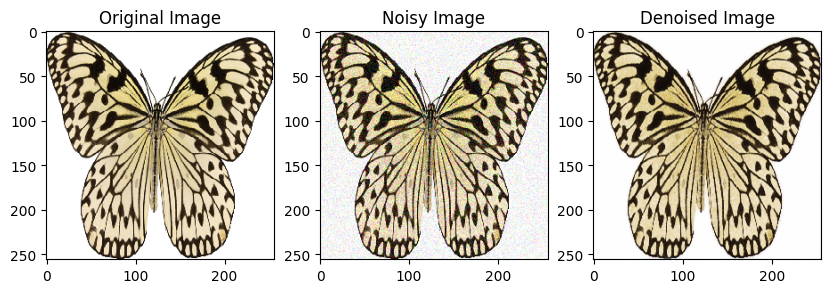

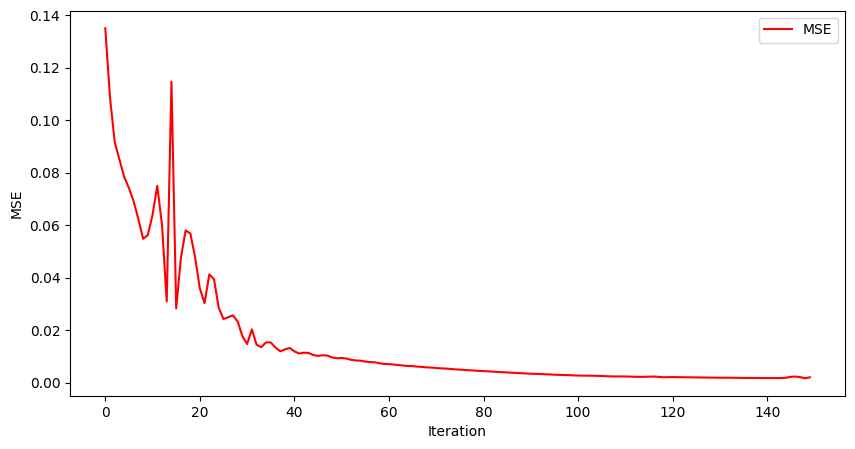

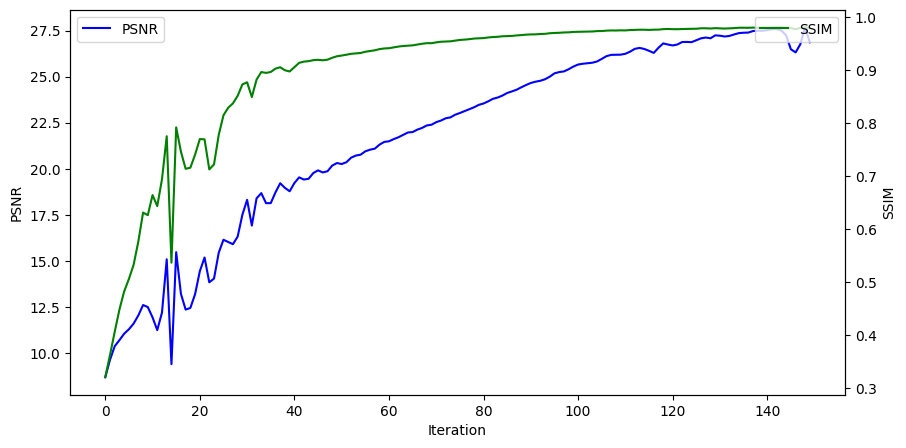

1/1 [==============================] - 0s 254ms/step
Epoch: 1, PSNR: 8.356855510457432, SSIM: 0.30471113324165344, MSE: 0.14598709344863892
1/1 [==============================] - 0s 27ms/step
Epoch: 2, PSNR: 9.032887052992484, SSIM: 0.3356318473815918, MSE: 0.12494280934333801
1/1 [==============================] - 0s 21ms/step
Epoch: 3, PSNR: 10.00200582727298, SSIM: 0.3546033203601837, MSE: 0.09995382279157639
1/1 [==============================] - 0s 21ms/step
Epoch: 4, PSNR: 9.765709758101842, SSIM: 0.4051071107387543, MSE: 0.10554289817810059
1/1 [==============================] - 0s 19ms/step
Epoch: 5, PSNR: 10.531464488608238, SSIM: 0.4266536235809326, MSE: 0.08848171681165695
1/1 [==============================] - 0s 20ms/step
Epoch: 6, PSNR: 10.840978878843108, SSIM: 0.4512956142425537, MSE: 0.08239524066448212
1/1 [==============================] - 0s 25ms/step
Epoch: 7, PSNR: 10.971527801318581, SSIM: 0.47694161534309387, MSE: 0.07995529472827911
1/1 [=======================

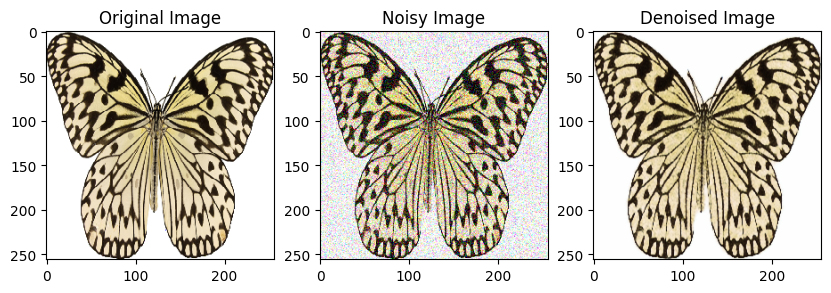

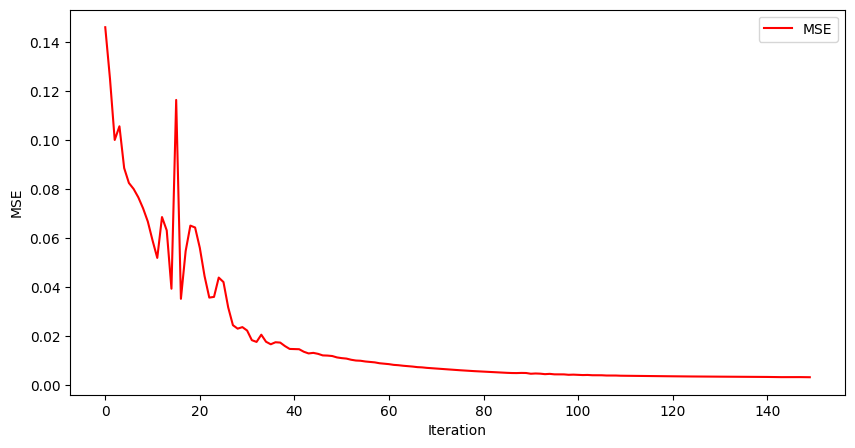

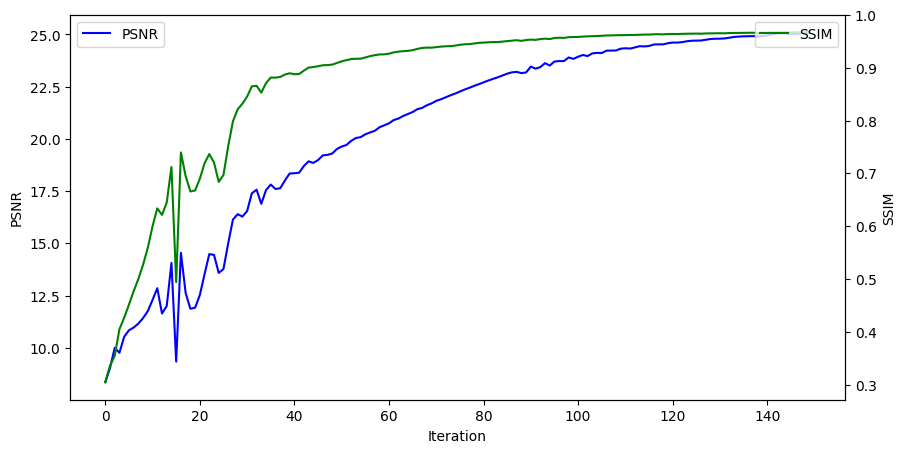

Results - PSNR: 25.104343066621905, SSIM: 0.9670038223266602, Generation Time: 0.07840704917907715 seconds


In [9]:
results = {}
model_architecture = 'unet'  # unet or dncnn or resnet
noise_levels = [0.01, 0.02]
for noise_level in noise_levels:
    mse_losses = []
    psnr_values = []
    ssim_values = []
    time_steps = []

    # add noise
    noisy_img = input_img + noise_level * np.random.normal(size=input_img.shape)
    noisy_img = np.clip(noisy_img, 0., 1.)


    if model_architecture == 'unet':
        model = build_unet()
    elif model_architecture == 'dncnn':
        model = build_dncnn()
    elif model_architecture == 'resnet':
        model = build_resnet()

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


    for epoch in range(150):
      model.fit(x=np.expand_dims(noisy_img, axis=0), y=np.expand_dims(input_img, axis=0), epochs=1, batch_size=1, verbose=1)

      denoised_img, gen_time = measure_time(model, noisy_img)

      # evaluate PSNR + SSIM + MSE
      psnr_value = compute_psnr(input_img, denoised_img[0])
      ssim_value = compute_ssim(input_img, denoised_img[0])
      loss_value = model.evaluate(np.expand_dims(noisy_img, axis=0), np.expand_dims(input_img, axis=0), verbose=0)

      mse_losses.append(loss_value)
      psnr_values.append(psnr_value)
      ssim_values.append(ssim_value)
      time_steps.append(epoch)

      print(f"Epoch: {epoch + 1}, PSNR: {psnr_value}, SSIM: {ssim_value}, MSE: {loss_value}")


    results['Results'] = {
      'PSNR': psnr_value,
      'SSIM': ssim_value,
      'Generation Time': gen_time
    }


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(input_img)

    plt.subplot(1, 3, 2)
    plt.title('Noisy Image')
    plt.imshow(noisy_img)

    plt.subplot(1, 3, 3)
    plt.title('Denoised Image')
    plt.imshow(denoised_img[0])

    plt.show()


    plot_performance(time_steps, mse_losses, psnr_values, ssim_values)


# print rslts
for key, value in results.items():
    print(f"{key} - PSNR: {value['PSNR']}, SSIM: {value['SSIM']}, Generation Time: {value['Generation Time']} seconds")